# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [5]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [6]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install tensorflow
#!pip install Pillow

以下のsolution関数のみ編集してください。

In [7]:
def solution(x_test_df, train_df):
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    import tensorflow as tf
    from sklearn.utils.class_weight import compute_class_weight
    from PIL import Image
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add
    from tensorflow.keras.models import Model

    def resize_map(map):

        resize_shape = (32, 32)

        non_zero_average = np.mean(map[map != 0])
        map[map == 0] = non_zero_average
    
        map = Image.fromarray(map - 1.0)
        resized_map = map.resize(resize_shape, Image.LANCZOS)

        return np.asarray(resized_map)

    
    def preprocess_map(df, resize_map):

        preprocessed_maps = np.array([resize_map(x) for x in df['waferMap']])

        rotated_90 = np.rot90(preprocessed_maps, k=1, axes=(1, 2))
        preprocessed_maps = np.concatenate((preprocessed_maps, rotated_90), axis=0)

        rotated_180 = np.rot90(preprocessed_maps, k=2, axes=(1, 2))
        preprocessed_maps = np.concatenate((preprocessed_maps, rotated_180), axis=0)

        flipped_horizontally = np.flip(preprocessed_maps, axis=2)
        preprocessed_maps = np.concatenate((preprocessed_maps, flipped_horizontally), axis=0)

        preprocessed_maps = preprocessed_maps.reshape(preprocessed_maps.shape + (1,))

        return preprocessed_maps

    
    def initialize_cnn(input_shape, failure_types_classes):
        inputs = Input(shape=input_shape)
    
        x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
        x = MaxPooling2D(pool_size=2, strides=2)(x)
        skip_connection = Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)

        x = Conv2D(64, 3, activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=2, strides=2)(x)
        x = Add()([x, skip_connection])

        x = Conv2D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=2, strides=2)(x)
    
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0)(x)
    
        outputs = Dense(failure_types_classes)(x)
    
        model = Model(inputs=inputs, outputs=outputs)
    
        return model


    def calculate_class_weights(train_labels):

        class_weights = compute_class_weight(class_weight='balanced', 
                                             classes=np.unique(train_labels), 
                                             y=train_labels)

        return dict(enumerate(class_weights))


    failure_types = list(train_df['failureType'].unique())

    train_maps = preprocess_map(train_df, resize_map)
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']] * 8)

    failure_types_classes = len(failure_types)
    input_shape = train_maps[0].shape

    class_weights = calculate_class_weights(train_labels)

    model = initialize_cnn(input_shape, failure_types_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    model.fit(train_maps, train_labels, epochs=10, batch_size=64, class_weight=class_weights)

    test_maps = preprocess_map(x_test_df, resize_map)
    map_classes = len(x_test_df['waferMap'])
    
    test_predictions = model.predict(test_maps)
    aggregated_logits = np.zeros(map_classes * failure_types_classes, dtype=np.float64).reshape((map_classes, failure_types_classes))
    for n in range(8):
        aggregated_logits += test_predictions[map_classes * n  :map_classes * (n + 1)]
    
    predictions = tf.nn.softmax(aggregated_logits).numpy()
    answer = [failure_types[x.argmax()] for x in predictions]
    
    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)

solution関数は以下のように活用され、平均精度を計算します。

Epoch 1/10
2871/2871 [==============================] - 50s 17ms/step - loss: 0.4532 - accuracy: 0.8331
Epoch 2/10
2871/2871 [==============================] - 52s 18ms/step - loss: 0.2650 - accuracy: 0.9027
Epoch 3/10
2871/2871 [==============================] - 53s 19ms/step - loss: 0.2045 - accuracy: 0.9244
Epoch 4/10
2871/2871 [==============================] - 53s 19ms/step - loss: 0.1668 - accuracy: 0.9376
Epoch 5/10
2871/2871 [==============================] - 54s 19ms/step - loss: 0.1379 - accuracy: 0.9464
Epoch 6/10
2871/2871 [==============================] - 55s 19ms/step - loss: 0.1197 - accuracy: 0.9522
Epoch 7/10
2871/2871 [==============================] - 54s 19ms/step - loss: 0.1048 - accuracy: 0.9580
Epoch 8/10
2871/2871 [==============================] - 55s 19ms/step - loss: 0.0885 - accuracy: 0.9624
Epoch 9/10
2871/2871 [==============================] - 56s 19ms/step - loss: 0.0818 - accuracy: 0.9664
Epoch 10/10
638/638 [==============================] - 2s 4ms/st

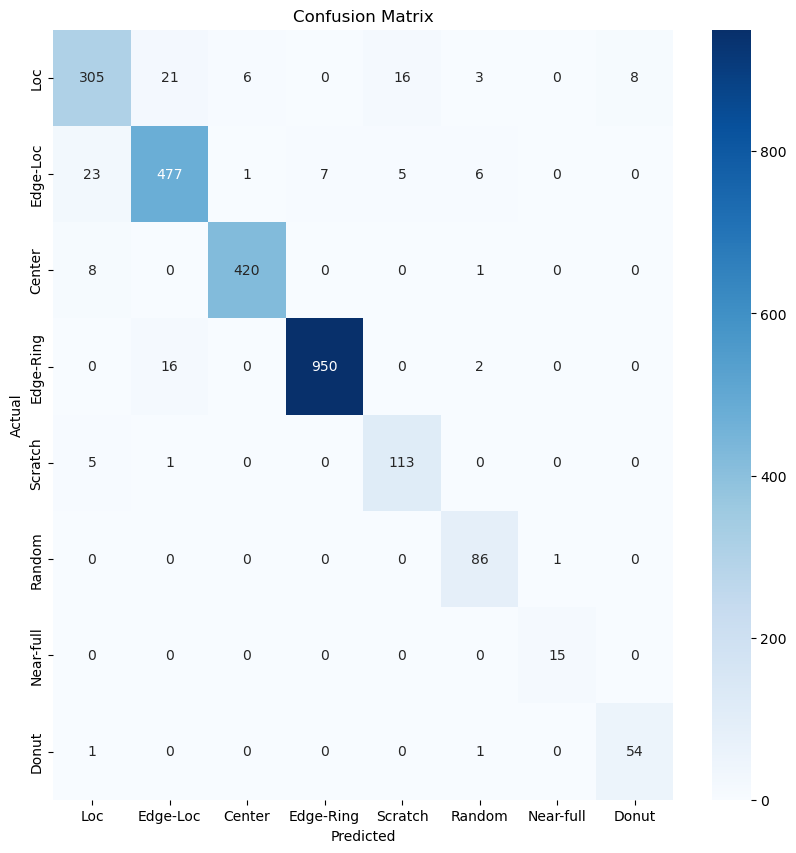


Class Accuracy and Most Common Errors:
Loc: Accuracy: 84.96%
    Most common error: Mistaken for Edge-Loc (5.85%)
Edge-Loc: Accuracy: 91.91%
    Most common error: Mistaken for Loc (4.43%)
Center: Accuracy: 97.90%
    Most common error: Mistaken for Loc (1.86%)
Edge-Ring: Accuracy: 98.14%
    Most common error: Mistaken for Edge-Loc (1.65%)
Scratch: Accuracy: 94.96%
    Most common error: Mistaken for Loc (4.20%)
Random: Accuracy: 98.85%
    Most common error: Mistaken for Near-full (1.15%)
Near-full: Accuracy: 100.00%
Donut: Accuracy: 96.43%
    Most common error: Mistaken for Random (1.79%)
平均精度：95.39%
9min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
%%timeit -r 1 -n 1

def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")